## Importing Libraries

In [1]:
%pip install pydot graphviz

import os
import h5py
import numpy as np
import pandas as pd
import pyarrow as pa
import tensorflow as tf
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Add, Input

Note: you may need to restart the kernel to use updated packages.


2024-03-25 07:12:41.671443: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 07:12:41.671542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 07:12:41.803411: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Disable Warnings

In [2]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

## Load the Dataset

In [3]:
def read_file(path):
  chunk_size = 25

# Create a Parquet file reader object
  parquet_file = pq.ParquetFile(path)

# Determine the total number of rows in the file
  total_rows = parquet_file.metadata.num_rows

# Loop over the file in chunks
  data = []
  for i in range(0, total_rows, chunk_size):
    # Read a chunk of rows from the file
      chunk = (parquet_file.read_row_group(i))
      dm = (chunk.to_pandas())
      data.append(dm)

# Concatenate all the DataFrames into a single DataFrame
  df = pd.concat(data, ignore_index=True)
  print(parquet_file.read_row_group(0).to_pandas())
  return df

In [4]:
df1 = read_file('/kaggle/input/common-task-2-dataset/Task - 2 Data (Parquet)/jet0_run0.test.snappy.parquet')
df2 = read_file('/kaggle/input/common-task-2-dataset/Task - 2 Data (Parquet)/jet0_run1.test.snappy.parquet')
df3 = read_file('/kaggle/input/common-task-2-dataset/Task - 2 Data (Parquet)/jet0_run2.test.snappy.parquet')

                                              X_jets          pt         m0  \
0  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  112.411095  21.098248   

     y  
0  0.0  
                                              X_jets          pt         m0  \
0  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  147.686737  32.114449   

     y  
0  0.0  
                                              X_jets          pt         m0  \
0  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  107.854118  18.723455   

     y  
0  0.0  


## Constructing X and y

In [5]:
def construct_X_y(df):
    # Get the total number of samples
    num_samples = len(df)

    # Initialize empty arrays for X and y
    X = np.empty((num_samples, 3, 125, 125), dtype=np.float32)
    y = np.empty(num_samples, dtype=int)

    # Iterate through the DataFrame and fill X and y
    for i, row in df.iterrows():
        # Stack the three channels of X_jets and transpose them to match the desired shape
        X[i] = np.transpose(np.dstack((np.stack(row['X_jets'][0]), np.stack(row['X_jets'][1]), np.stack(row['X_jets'][2]))), (2, 0, 1))
        # Assign the label to y
        y[i] = row['y']

    # Rearrange the dimensions of X to match the TensorFlow format (samples, height, width, channels)
    X = np.transpose(X, (0, 2, 3, 1))

    return X, y

In [6]:
# Assuming 'df' is the pandas DataFrame
X1, y1 = construct_X_y(df1)
X2, y2 = construct_X_y(df2)
X3, y3 = construct_X_y(df3)

In [7]:
# Save X1 array to binary file 'X1.npy'
with open('X1.npy', 'wb') as f:
    np.save(f, X1)

# Save y1 array to binary file 'y1.npy'
with open('y1.npy', 'wb') as f:
    np.save(f, y1)

# Save X2 array to binary file 'X2.npy'
with open('X2.npy', 'wb') as f:
    np.save(f, X2)

# Save y2 array to binary file 'y2.npy'
with open('y2.npy', 'wb') as f:
    np.save(f, y2)

# Save X3 array to binary file 'X3.npy'
with open('X3.npy', 'wb') as f:
    np.save(f, X3)

# Save y3 array to binary file 'y3.npy'
with open('y3.npy', 'wb') as f:
    np.save(f, y3)

In [8]:
x1 = np.load('X1.npy')
x2 = np.load('X2.npy')
x3 = np.load('X3.npy')

y1 = np.load('y1.npy')
y2 = np.load('y2.npy')
y3 = np.load('y3.npy')

In [9]:
# Combine x arrays along the first axis (axis=0)
x = np.concatenate((x1, x2, x3), axis=0)

# Combine y arrays along the first axis (axis=0)
y = np.concatenate((y1, y2, y3), axis=0)

# Save the combined X array to a binary file named 'X.npy'
with open('x.npy', 'wb') as f:
    np.save(f, x)

# Save the combined y array to a binary file named 'y.npy'
with open('y.npy', 'wb') as f:
    np.save(f, y)

In [10]:
# Loading the content of x.npy into the variable x
x = np.load('x.npy')

# Loading the content of y.npy into the variable y
y = np.load('y.npy')

## Similar to VGG with 12 layers Model Creation

In [11]:
# Create a Sequential model
model = Sequential()

# First convolutional block
model.add(Conv2D(64, (3, 3), activation="relu", padding="same", input_shape=(125, 125, 3)))
model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))


# Four more convolutional blocks with increasing filter numbers
for filters in [128, 256, 256, 256]:
    model.add(Conv2D(filters, (3, 3), activation="relu", padding="same"))
    model.add(Conv2D(filters, (3, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Flatten the output for fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(4096, activation="relu"))
model.add(Dense(4096, activation="relu")) 
model.add(Dense(1, activation='sigmoid'))

# Define the optimizer (Adam) with a learning rate of 1e-4
optimizer = Adam(learning_rate=1e-4)

# Compile the model with binary crossentropy loss and accuracy metric
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 125, 125, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 31, 31, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 31, 31, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 15, 15, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     9,441,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,732,417 (113.42 MB)

 Trainable params: 29,732,417 (113.42 MB)

 Non-trainable params: 0 (0.00 B)

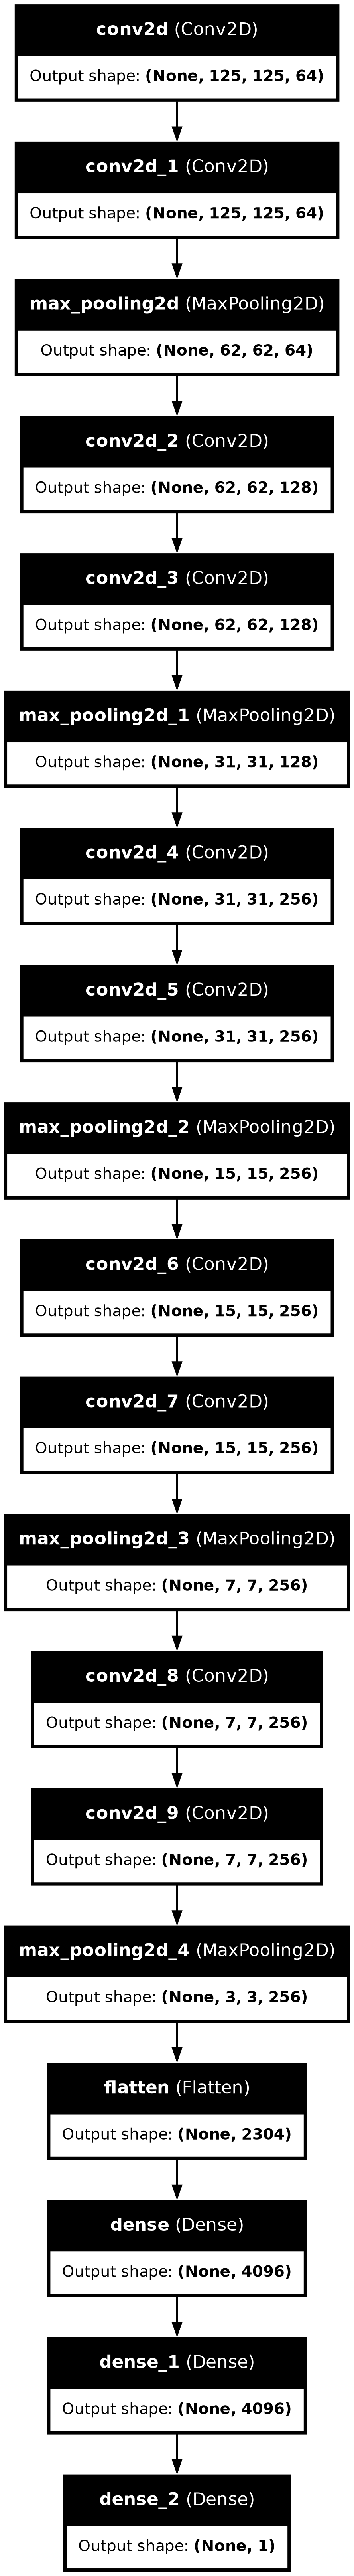

In [13]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Data Splitting

In [14]:
xtrain, xtest, ytrain, ytest = train_test_split(x,
                                               y,
                                               test_size = 0.2,
                                               random_state = 42)

## Model Training

In [15]:
history = model.fit(xtrain, 
                    ytrain, 
                    epochs=2, 
                    batch_size=8, 
                    validation_split=0.1, 
                    verbose=1)

Epoch 1/2


2024-03-25 07:13:45.485898: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15625: 3.14988, expected 2.35139
2024-03-25 07:13:45.485961: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15626: 4.78672, expected 3.98824
2024-03-25 07:13:45.485976: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15627: 6.03375, expected 5.23526
2024-03-25 07:13:45.486001: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15628: 6.17867, expected 5.38018
2024-03-25 07:13:45.486014: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15630: 6.82997, expected 6.03149
2024-03-25 07:13:45.486025: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15631: 6.72692, expected 5.92843
2024-03-25 07:13:45.486035: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15633: 6.1838, expected 5.38532
2024-03-25 07:13:45.486046: 

  7/502 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.4486 - loss: 0.6965 

I0000 00:00:1711350831.816963     122 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711350831.841572     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


499/502 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5812 - loss: 0.6825

2024-03-25 07:14:02.216157: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.56937, expected 2.92516
2024-03-25 07:14:02.216221: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.02387, expected 2.37967
2024-03-25 07:14:02.216231: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.54004, expected 3.89583
2024-03-25 07:14:02.216240: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.09986, expected 4.45565
2024-03-25 07:14:02.216248: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.45816, expected 3.81396
2024-03-25 07:14:02.216257: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.17383, expected 4.52963
2024-03-25 07:14:02.216265: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 5.35262, expected 4.70841
2024-03-25 07:14:02.216274: E external/local_xla/xla/se

502/502 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5815 - loss: 0.6823

W0000 00:00:1711350847.966117     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-03-25 07:14:08.440273: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.11701, expected 2.35351
2024-03-25 07:14:08.440357: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.74674, expected 2.98324
2024-03-25 07:14:08.440367: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.51069, expected 4.74718
2024-03-25 07:14:08.440376: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.987, expected 4.2235
2024-03-25 07:14:08.440385: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.19833, expected 5.43482
2024-03-25 07:14:08.440393: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.08456, expected 5.32105
2024-03-25 07:14:08.440401: E external/local_xla/xla/service/gpu/buf

502/502 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - accuracy: 0.5816 - loss: 0.6823 - val_accuracy: 0.6637 - val_loss: 0.6117
Epoch 2/2
502/502 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.6743 - loss: 0.6209 - val_accuracy: 0.6839 - val_loss: 0.6092


### Prediction Probability

In [16]:
y_pred_probs = model.predict(xtest)

2024-03-25 07:14:21.482271: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.43505, expected 2.04048
2024-03-25 07:14:21.482409: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15624: 2.7146, expected 2.32004
2024-03-25 07:14:21.482493: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31181: 2.35534, expected 2.0195
2024-03-25 07:14:21.482502: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31249: 1.93263, expected 1.59678
2024-03-25 07:14:21.482535: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 33499: 2.10129, expected 1.76903
2024-03-25 07:14:21.482980: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 93750: 3.83611, expected 2.97959
2024-03-25 07:14:21.483013: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 93751: 5.87899, expected 5.02247
2024-03-25 07:14:21.483022: E ext

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

2024-03-25 07:14:27.088517: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.04372, expected 2.47797
2024-03-25 07:14:27.088576: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.27935, expected 3.7136
2024-03-25 07:14:27.088585: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 23: 4.38252, expected 3.81677
2024-03-25 07:14:27.088594: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 24: 3.82394, expected 3.25819
2024-03-25 07:14:27.088602: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 28: 3.93545, expected 3.36971
2024-03-25 07:14:27.088610: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 4.59424, expected 4.02849
2024-03-25 07:14:27.088618: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 51: 4.56387, expected 3.99813
2024-03-25 07:14:27.088626: E external/local_xla/xl

35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step


### ROC-AUC Score

In [17]:
roc_auc = roc_auc_score(ytest, y_pred_probs)
print(f'ROC AUC score: {roc_auc}')

ROC AUC score: 0.7534671203567653


In [18]:
# Calculate the false positive rate (false_pr), true positive rate (true_pr), and thresholds
false_pr, true_pr, thresholds = roc_curve(ytest, y_pred_probs)

### Calculate the ROC-AUC Scores

In [19]:
roc_auc = auc(false_pr, true_pr)

## Plotting ROC-AUC Curve

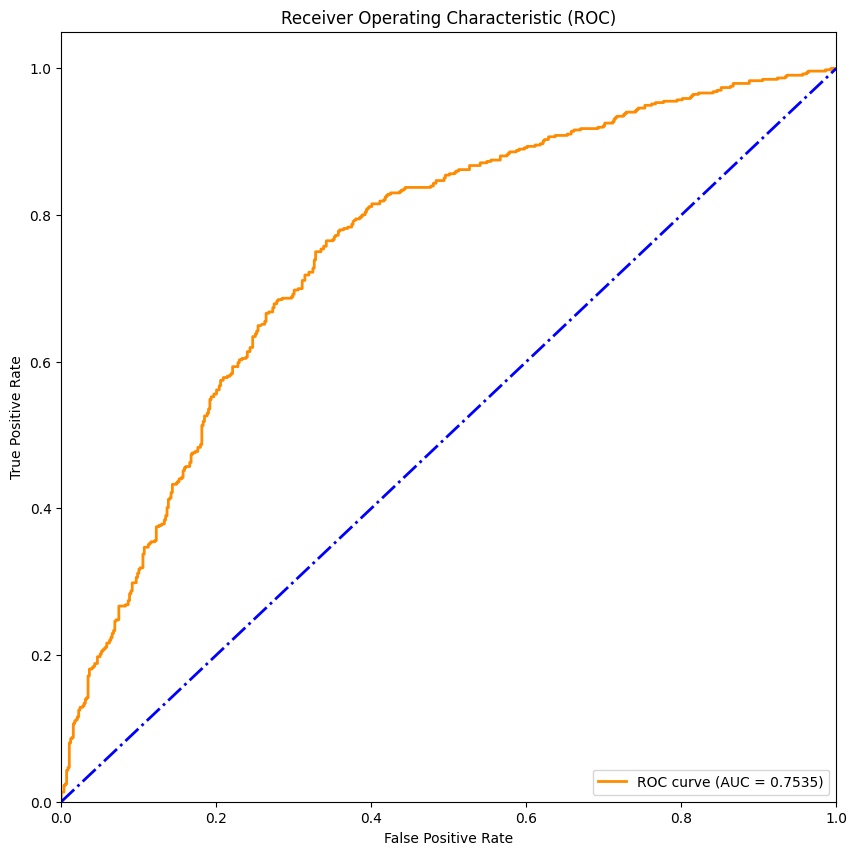

In [20]:
plt.figure(figsize = (10, 10))
lw = 2
plt.plot(false_pr, true_pr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='-.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()